# Correlation of Speech Features and Demographics / Neuropsychological Questionnaires

##### Import modules

In [20]:
import pandas as pd
import plotly.graph_objects as go # plot heatmap of correlation
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import plotly
import matplotlib
import scipy
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests


In [21]:
# Print the versions of the packages
versions = {
    "pandas": pd.__version__,
    "plotly": plotly.__version__,
    "seaborn": sns.__version__,
    "matplotlib": matplotlib.__version__,
    "numpy": np.__version__,
    "scipy": scipy.__version__
}
versions

{'pandas': '1.1.3',
 'plotly': '4.14.3',
 'seaborn': '0.11.0',
 'matplotlib': '3.3.2',
 'numpy': '1.23.2',
 'scipy': '1.10.1'}

##### Select Speech Features

In [22]:
speech_demographic_info_path = 'W:/Fmri_Forschung/Allerlei/JuliaS/GitHub/SubliminalVideoPriming/data/speech/combined_speech_demographic_info.csv'
speech_demographic_info_df = pd.read_csv(speech_demographic_info_path, delimiter=';')
speech_demographic_info_df.head()

,bids_number,participant_id,average_mfccs_1_neg,average_mfccs_2_neg,average_mfccs_3_neg,average_mfccs_4_neg,alpha_ratio_mean_neg,alpha_ratio_sd_neg,apq11_shimmer_neg,apq3_shimmer_neg,...,CERQ_Andere Beschuldigen Norm,CERQ_Selbstbeschuldigung,CERQ_Akzeptanz,CERQ_Rumination,CERQ_Positive Refokussierung,CERQ_Refokussierung auf Planung,CERQ_Positive Neubewertung,CERQ_Relativieren,CERQ_Katastrophisierung,CERQ_Andere Beschuldigen
0,Sub-058,277,82.379395,20.768499,19.860287,8.051362,7.284629,6.096077,11.421412,5.298905,...,-0.1598,18,9,10,4,7,5,4,13,5
1,Sub-035,234,91.421997,32.314178,19.888418,9.289201,10.718941,7.867776,18.531850,8.018380,...,-0.1598,12,16,17,4,8,8,12,8,5
2,Sub-034,235,70.376846,13.177592,12.432057,1.496185,7.619763,7.617054,9.548101,5.130727,...,0.3557,9,16,14,12,16,16,18,4,6
3,Sub-108,348,97.495644,11.368194,25.960098,13.172879,7.972128,7.190350,15.057472,6.300391,...,0.8711,11,11,10,7,14,10,14,5,7
4,Sub-046,260,80.037323,21.050978,8.607089,5.815983,12.940309,12.775001,10.540608,4.699568,...,5.5103,6,17,14,8,10,9,13,7,16


##### Create dataset

Combine Speech Features with Questionnaire Results

In [23]:
# Identify columns related to questionnaire results
questionnaire_cols = [col for col in speech_demographic_info_df.columns if col.startswith('CERQ_') or col in [
    'BVAQ_New', 'BDI-II Sum score', 'STAI2', 'STAI1', 'WMS Correct Norm', 'WMS Correct',
    'Error B Norm', 'TM B Norm', 'B/A Norm', 'B/A', 'TM A', 'TM Practice A', 'TM B',
    'TM Practice B', 'Error A', 'Error B', 'Hamilton Score Norm', 'Hamilton Score',
    'DigitSpan_Forwards_Span', 'DigitSpan_ForwardsTotal Score', 'DigitSpan_Backwards_Span',
    'DigitSpan_Backwards_Total Score', 'DERS_Gesamtwert', 'DERS_Gesamtwert Norm',
    'DERS_Nicht-Akzeptanz emotionalerReaktionen Norm', 'DERS_Probleme mit zielorientiertem Verhalten Norm',
    'DERS_Impulskontrollprobleme Norm', 'DERS_Mangel an emotionaler Aufmerksamkeit Norm',
    'DERS_Eingeschränkter Zugang zu Emotionsregulations-Strategien Norm', 'DERS_Mangel an emotionaler Klarheit Norm',
    'DERS_Nicht-Akzeptanz emotionalerReaktionen', 'DERS_Probleme mit zielorientiertem Verhalten',
    'DERS_Impulskontrollprobleme', 'DERS_Mangel an emotionaler Aufmerksamkeit',
    'DERS_Eingeschränkter Zugang zu Emotionsregulations-Strategien', 'DERS_Mangel an emotionaler Klarheit'
]]

# Select the category columns and questionnaire result columns
speech_cols = ["duration_pos", "loudness_mean_pos", "pause_durations_sum_pos", "pause_durations_mean_pos", "number_of_pauses_pos","word_frequency_mean_pos", "word_count_pos", 
                 "negative_sentence_ratio_pos", "neutral_sentence_ratio_pos", "positive_sentence_ratio_pos", "duration_neg", "loudness_mean_neg","pause_durations_sum_neg", 
                 "pause_durations_mean_neg","number_of_pauses_neg", "word_frequency_mean_neg", "word_count_neg", "negative_sentence_ratio_neg", "neutral_sentence_ratio_neg", "positive_sentence_ratio_neg"]
selected_cols = ['bids_number','Gender', 'Alter', 'Gender_f1_m2', 'Group_MDD1_HC2'] + speech_cols + questionnaire_cols 


# Filter the dataframe to include only the selected columns
analysis_df = speech_demographic_info_df[selected_cols]
# Recode Group: Set HC (originally coded as 2) to 0, and MDD (originally coded as 1) to 1
analysis_df['Group_recode'] = analysis_df['Group_MDD1_HC2'].replace({2: 0, 1: 1})


# Dictionary to map German column names to English column names
translation_dict = {
    'Gender': 'Gender',
    'Alter': 'Age',
    'Gender_f1_m2': 'Sex',
    'Group_MDD1_HC2': 'Group',
    'BVAQ_New': 'BVAQ',
    'BDI-II Sum score': 'BDI',
    'STAI2': 'STAI2',
    'STAI1': 'STAI1',
    'WMS Correct Norm': 'WMS_Correct_Norm',
    'WMS Correct': 'WMS_Correct',
    'Error B Norm': 'Error_B_Norm',
    'TM B Norm': 'TM_B_Norm',
    'B/A Norm': 'B_A_Norm',
    'B/A': 'B_A',
    'TM A': 'TM_A',
    'TM Practice A': 'TM_Practice _A',
    'TM B': 'TM_B',
    'TM Practice B': 'TM_Practice_B',
    'Error A': 'Error_A',
    'Error B': 'Error_B',
    'Hamilton Score Norm': 'Hamilton_Score_Norm',
    'Hamilton Score': 'Hamilton_Score',
    'DigitSpan_Forwards_Span': 'DigitSpan_Forwards_Span',
    'DigitSpan_ForwardsTotal Score': 'DigitSpan_Forwards_Total_Score',
    'DigitSpan_Backwards_Span': 'DigitSpan_Backwards_Span',
    'DigitSpan_Backwards_Total Score': 'DigitSpan_Backwards_Total_Score',
    'DERS_Gesamtwert': 'DERS_Total_Score',
    'DERS_Gesamtwert Norm': 'DERS_Total_Score_Norm',
    'DERS_Nicht-Akzeptanz emotionalerReaktionen Norm': 'DERS Non-Acceptance of Emotional Reactions Norm',
    'DERS_Probleme mit zielorientiertem Verhalten Norm': 'DERS Problems with Goal-Oriented Behavior Norm',
    'DERS_Impulskontrollprobleme Norm': 'DERS Impulse Control Problems Norm',
    'DERS_Mangel an emotionaler Aufmerksamkeit Norm': 'DERS Lack of Emotional Awareness Norm',
    'DERS_Eingeschränkter Zugang zu Emotionsregulations-Strategien Norm': 'DERS Limited Access to Emotion Regulation Strategies Norm',
    'DERS_Mangel an emotionaler Klarheit Norm': 'DERS Lack of Emotional Clarity Norm',
    'DERS_Nicht-Akzeptanz emotionalerReaktionen': 'DERS_Non_Acceptance_of_Emotional_Reactions',
    'DERS_Probleme mit zielorientiertem Verhalten': 'DERS_Problems_with_Goal_Oriented_Behavior',
    'DERS_Impulskontrollprobleme': 'DERS_Impulse_Control_Problems',
    'DERS_Mangel an emotionaler Aufmerksamkeit': 'DERS_Lack_of_Emotional_Awareness',
    'DERS_Eingeschränkter Zugang zu Emotionsregulations-Strategien': 'DERS_Limited_Access_to_Emotion_Regulation_Strategies',
    'DERS_Mangel an emotionaler Klarheit': 'DERS_Lack_of_Emotional_Clarity',
    'CERQ_Selbstbeschuldigung Norm': 'CERQ Self-Blame Norm',
    'CERQ_Akzeptanz Norm': 'CERQ Acceptance Norm',
    'CERQ_Rumination Norm': 'CERQ Rumination Norm',
    'CERQ_Positive Refokussierung Norm': 'CERQ Positive Refocusing Norm',
    'CERQ_Refokussierung auf Planung Norm': 'CERQ Refocusing on Planning Norm',
    'CERQ_Positive Neubewertung Norm': 'CERQ Positive Reappraisal Norm',
    'CERQ_Relativieren Norm': 'CERQ Putting into Perspective Norm',
    'CERQ_Katastrophisierung Norm': 'CERQ Catastrophizing Norm',
    'CERQ_Andere Beschuldigen Norm': 'CERQ Other-Blame Norm',
    'CERQ_Selbstbeschuldigung': 'CERQ_Self_Blame',
    'CERQ_Akzeptanz': 'CERQ_Acceptance',
    'CERQ_Rumination': 'CERQ_Rumination',
    'CERQ_Positive Refokussierung': 'CERQ_Positive_Refocusing',
    'CERQ_Refokussierung auf Planung': 'CERQ_Refocusing_on_Planning',
    'CERQ_Positive Neubewertung': 'CERQ_Positive_Reappraisal',
    'CERQ_Relativieren': 'CERQ_Putting_into_Perspective',
    'CERQ_Katastrophisierung': 'CERQ_Catastrophizing',
    'CERQ_Andere Beschuldigen': 'CERQ_Other_Blame'
}

# Translate the column names
analysis_df.rename(columns=translation_dict, inplace=True)

<ipython-input-23-d36841bda5e1>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['Group_recode'] = analysis_df['Group_MDD1_HC2'].replace({2: 0, 1: 1})
c:\Users\juhoffmann\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [24]:
analysis_df.to_csv('W:/Fmri_Forschung/Allerlei/JuliaS/GitHub/SubliminalVideoPriming/data/speech/speech_categories.csv', index=False)
analysis_df.head()

,bids_number,Gender,Age,Sex,Group,duration_pos,loudness_mean_pos,pause_durations_sum_pos,pause_durations_mean_pos,number_of_pauses_pos,...,CERQ_Self_Blame,CERQ_Acceptance,CERQ_Rumination,CERQ_Positive_Refocusing,CERQ_Refocusing_on_Planning,CERQ_Positive_Reappraisal,CERQ_Putting_into_Perspective,CERQ_Catastrophizing,CERQ_Other_Blame,Group_recode
0,Sub-058,female,24,1,2,11.935063,-56.788425,4.09,0.136333,30,...,18,9,10,4,7,5,4,13,5,0
1,Sub-035,female,30,1,1,70.472562,-50.704731,39.15,0.323554,121,...,12,16,17,4,8,8,12,8,5,1
2,Sub-034,female,25,1,2,43.444563,-52.904180,26.70,0.317857,84,...,9,16,14,12,16,16,18,4,6,0
3,Sub-108,male,26,2,1,61.625750,-50.562834,26.78,0.250280,107,...,11,11,10,7,14,10,14,5,7,1
4,Sub-046,female,30,1,2,7.082125,-65.337544,3.76,0.235000,16,...,6,17,14,8,10,9,13,7,16,0


## Correlation per group

In [29]:
# Select the category columns and questionnaire result columns
speech_col = ["duration_pos", "loudness_mean_pos", "pause_durations_sum_pos", "pause_durations_mean_pos", "number_of_pauses_pos","word_frequency_mean_pos", "word_count_pos", 
                 "negative_sentence_ratio_pos", "neutral_sentence_ratio_pos", "positive_sentence_ratio_pos", "duration_neg", "loudness_mean_neg","pause_durations_sum_neg", 
                 "pause_durations_mean_neg","number_of_pauses_neg", "word_frequency_mean_neg", "word_count_neg", "negative_sentence_ratio_neg", "neutral_sentence_ratio_neg", "positive_sentence_ratio_neg"]

questionnaire_col = ['BVAQ','BDI','STAI2','STAI1',
                     'DERS_Total_Score','DERS_Non_Acceptance_of_Emotional_Reactions','DERS_Problems_with_Goal_Oriented_Behavior',
                     'DERS_Impulse_Control_Problems','DERS_Lack_of_Emotional_Awareness','DERS_Limited_Access_to_Emotion_Regulation_Strategies',
                     'DERS_Lack_of_Emotional_Clarity','CERQ_Self_Blame','CERQ_Acceptance','CERQ_Rumination','CERQ_Positive_Refocusing',
                     'CERQ_Refocusing_on_Planning','CERQ_Positive_Reappraisal','CERQ_Putting_into_Perspective','CERQ_Catastrophizing','CERQ_Other_Blame']

selected_cols = ['Group_recode'] + speech_col + questionnaire_col


# Filter the dataframe to include only the selected columns
df = analysis_df[selected_cols]
df

,Group_recode,duration_pos,loudness_mean_pos,pause_durations_sum_pos,pause_durations_mean_pos,number_of_pauses_pos,word_frequency_mean_pos,word_count_pos,negative_sentence_ratio_pos,neutral_sentence_ratio_pos,...,DERS_Lack_of_Emotional_Clarity,CERQ_Self_Blame,CERQ_Acceptance,CERQ_Rumination,CERQ_Positive_Refocusing,CERQ_Refocusing_on_Planning,CERQ_Positive_Reappraisal,CERQ_Putting_into_Perspective,CERQ_Catastrophizing,CERQ_Other_Blame
0,0,11.935063,-56.788425,4.09,0.136333,30,4.750000,32,0.000000,0.333333,...,10,18,9,10,4,7,5,4,13,5
1,1,70.472562,-50.704731,39.15,0.323554,121,4.747556,161,0.000000,0.111111,...,8,12,16,17,4,8,8,12,8,5
2,0,43.444563,-52.904180,26.70,0.317857,84,5.047419,80,0.166667,0.166667,...,10,9,16,14,12,16,16,18,4,6
3,1,61.625750,-50.562834,26.78,0.250280,107,4.746415,145,0.090909,0.363636,...,9,11,11,10,7,14,10,14,5,7
4,0,7.082125,-65.337544,3.76,0.235000,16,5.073333,19,0.000000,1.000000,...,16,6,17,14,8,10,9,13,7,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0,16.230750,-50.753924,7.36,0.198919,37,5.030000,43,0.000000,0.500000,...,8,5,15,18,12,20,13,18,8,19
90,1,12.260125,-41.397093,3.37,0.124815,27,4.178889,24,0.000000,1.000000,...,16,17,13,8,9,12,12,15,7,10
91,1,10.750875,-45.488807,2.83,0.217692,13,5.073000,23,0.000000,1.000000,...,22,16,16,15,10,14,6,7,9,9
92,1,27.120938,-59.995381,18.26,0.793913,23,4.751176,50,0.000000,0.800000,...,23,13,8,12,4,10,10,12,6,7


Analyzing Group 0...


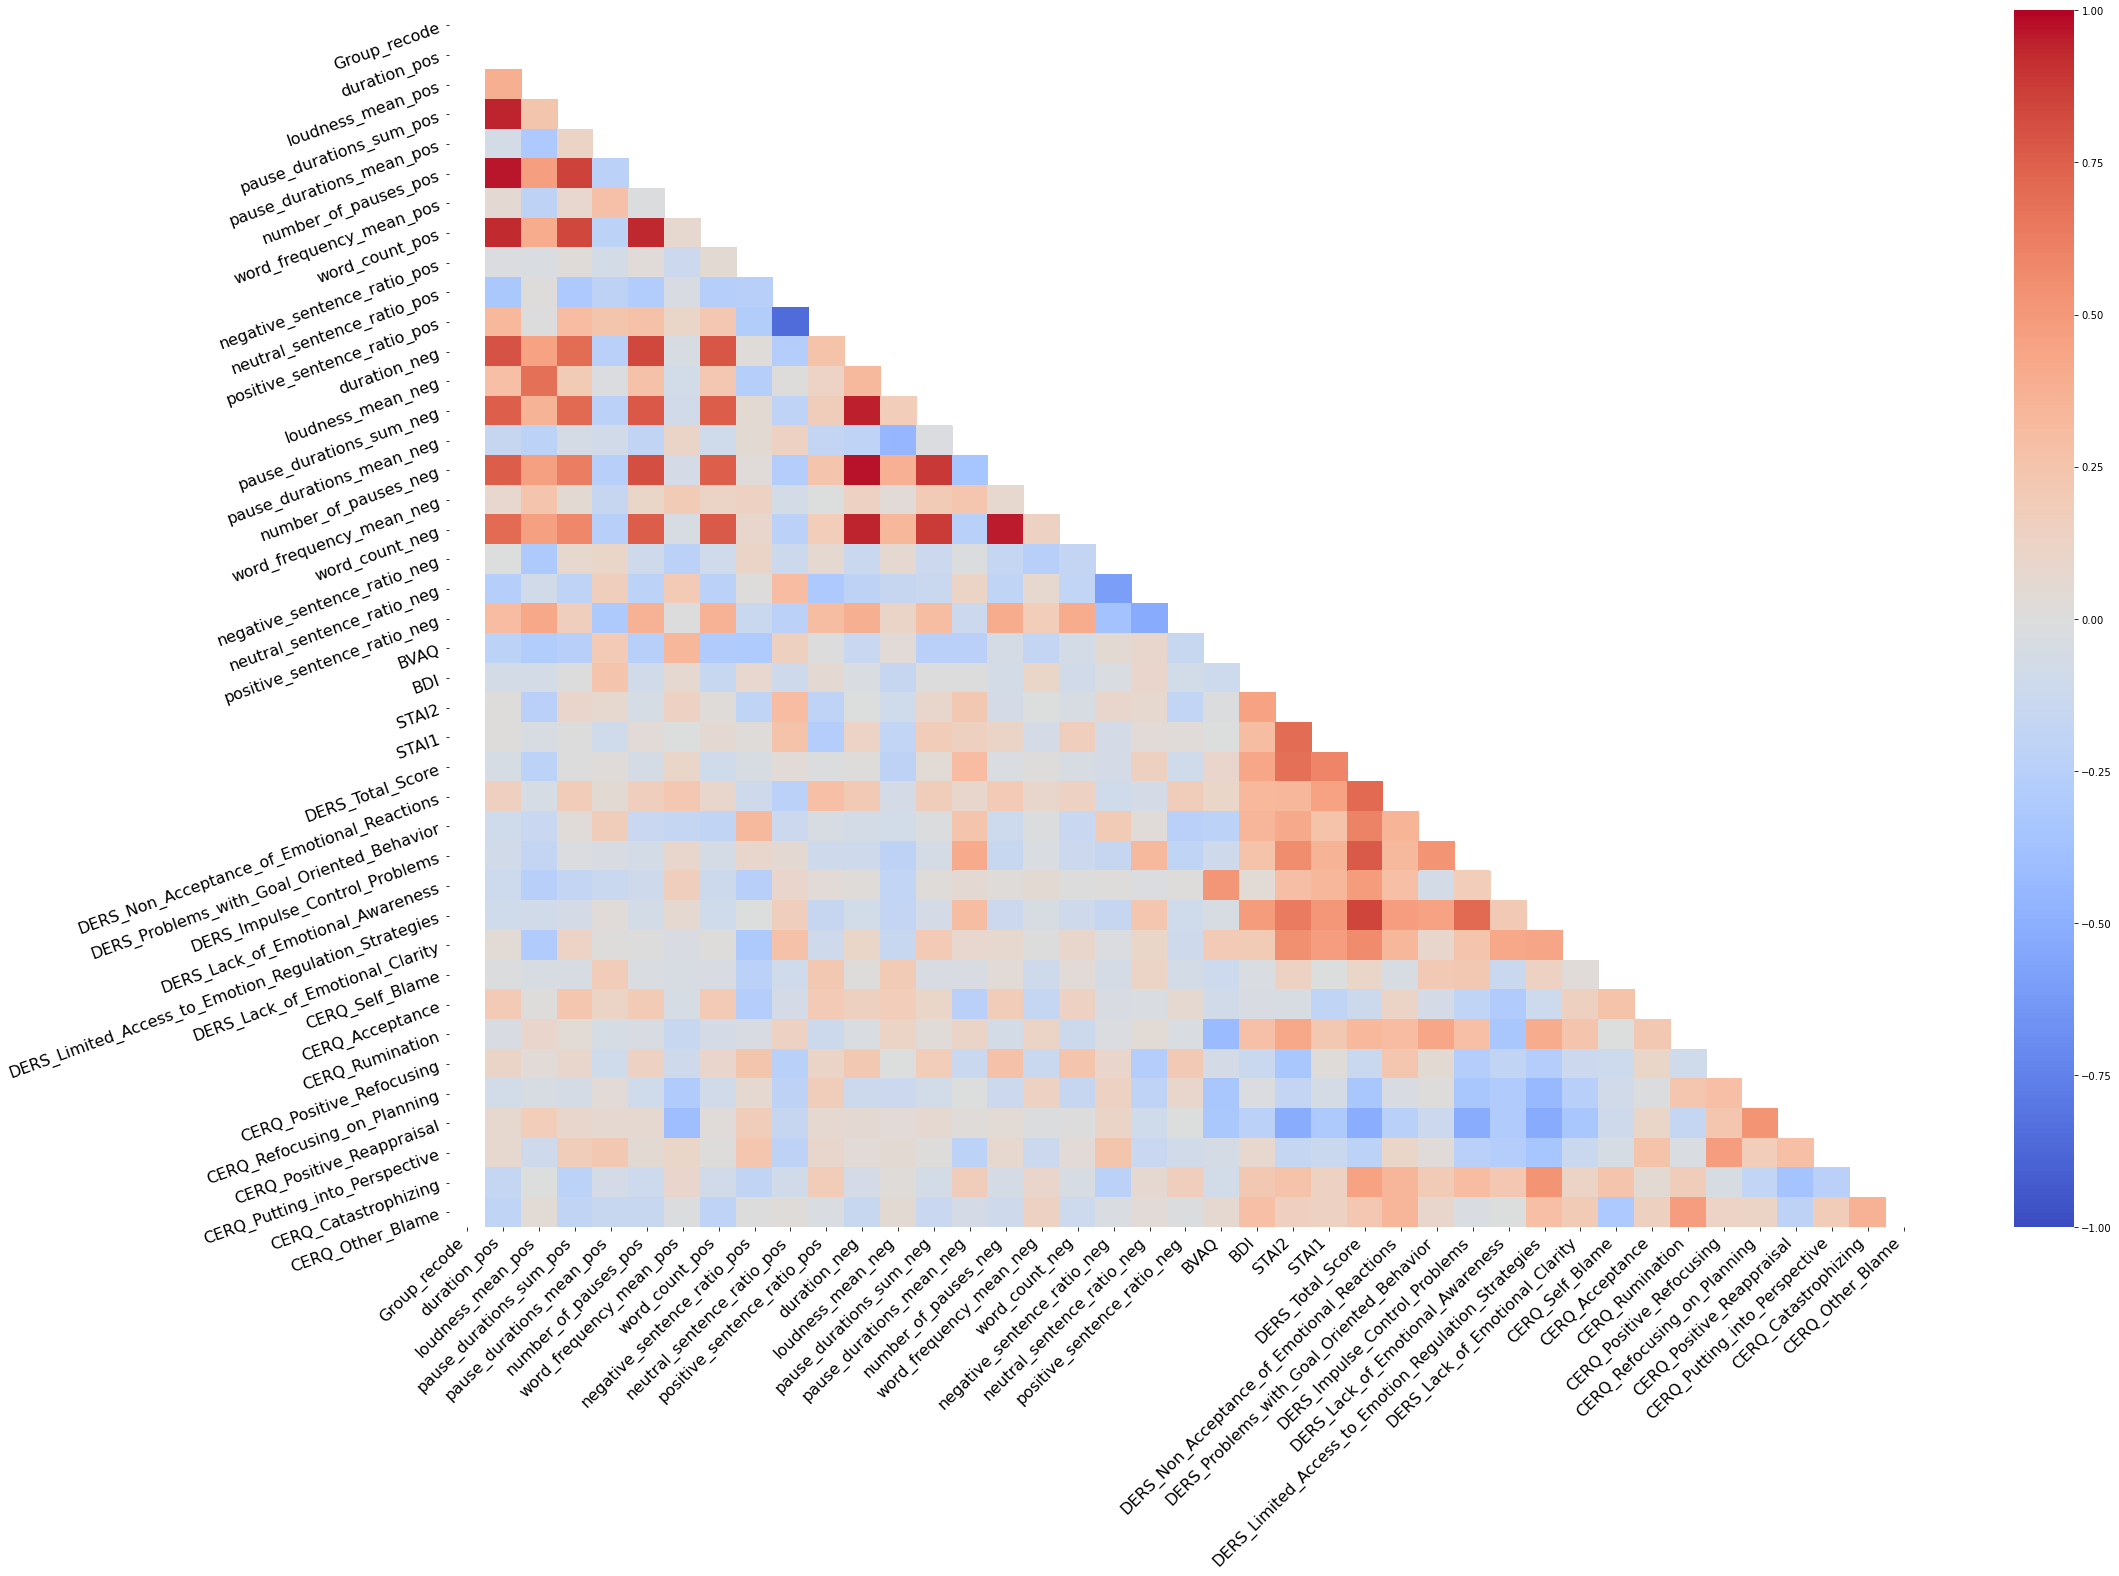

c:\Users\juhoffmann\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Correlation Matrix Summary:
Number of comparisons corrected for Bonferroni: 1681
Bonferroni correction threshold: 2.9744199881023203e-05
P-Value Matrix Summary:
       Group_recode  duration_pos  loudness_mean_pos  pause_durations_sum_pos  \
count           1.0     40.000000          40.000000                40.000000   
mean            0.0      0.387108           0.349130                 0.391061   
std             NaN      0.345610           0.361604                 0.344628   
min             0.0      0.000000           0.000000                 0.000000   
25%             0.0      0.026212           0.026539                 0.073122   
50%             0.0      0.368484           0.145507                 0.261829   
75%             0.0      0.633896           0.760952                 0.702633   
max             0.0      0.999894           0.988703                 0.986529   

       pause_durations_mean_pos  number_of_pauses_pos  \
count                 40.000000             40.00000

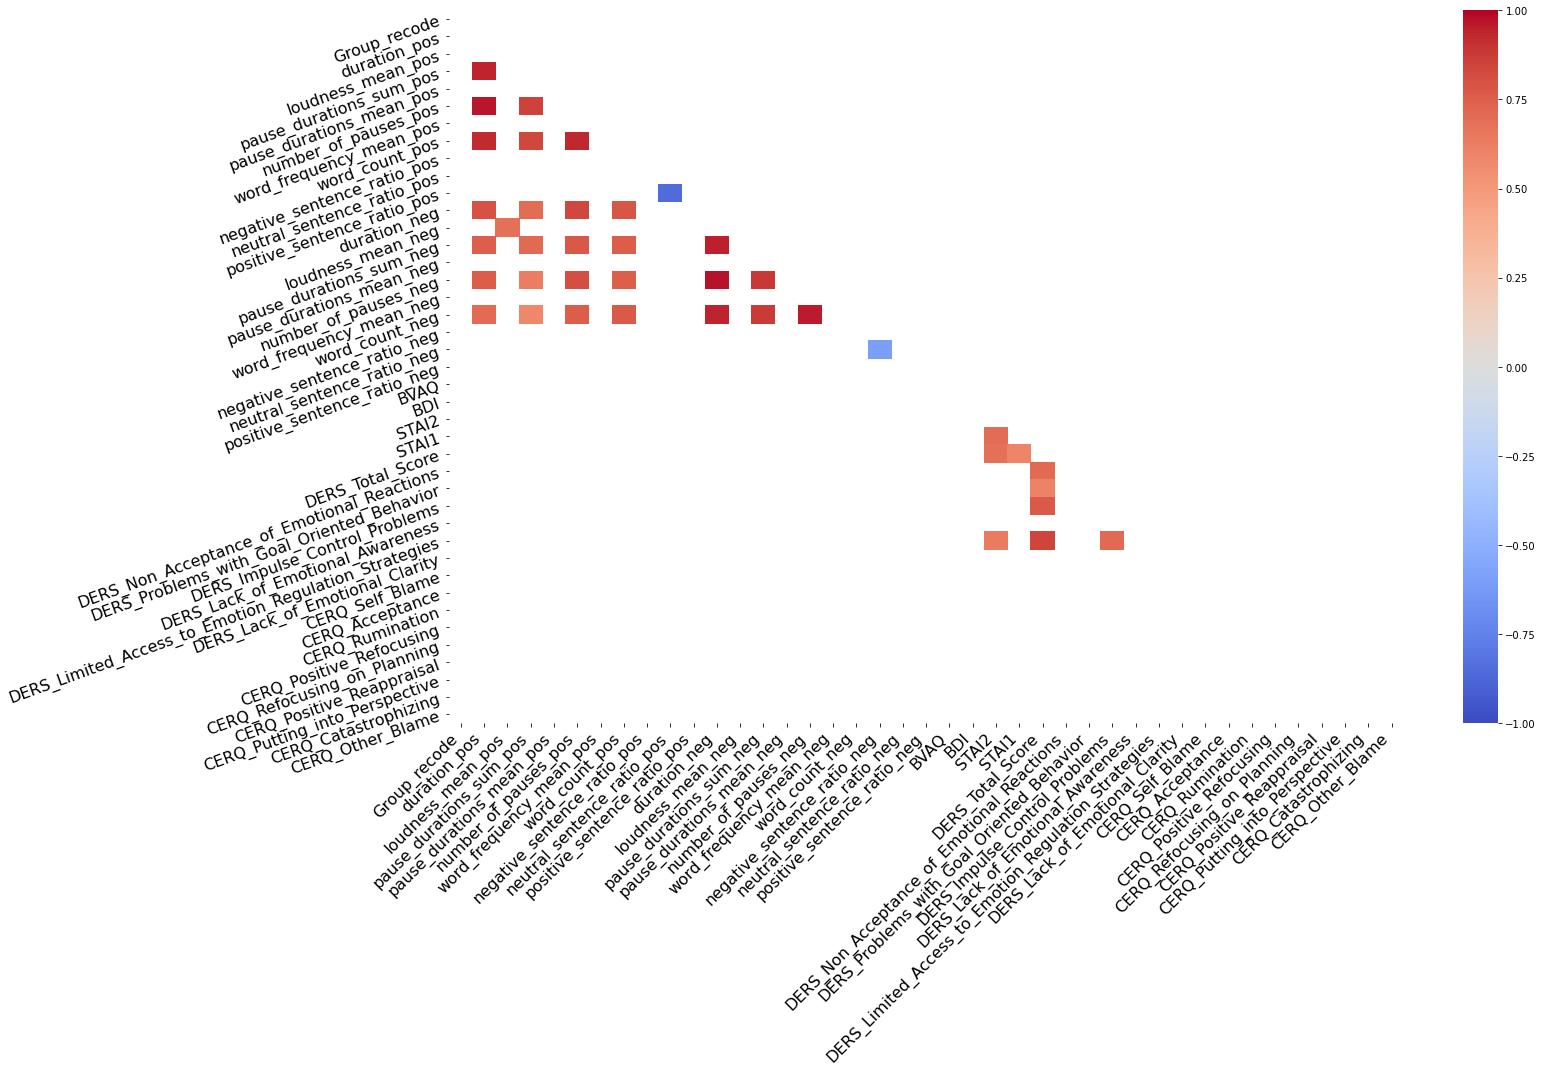

Significant Correlations Summary:
       Group_recode  duration_pos  loudness_mean_pos  pause_durations_sum_pos  \
count           0.0      8.000000           2.000000                 8.000000   
mean            NaN      0.857257           0.840650                 0.781354   
std             NaN      0.113582           0.225355                 0.149379   
min             NaN      0.703899           0.681300                 0.578579   
25%             NaN      0.758400           0.760975                 0.681600   
50%             NaN      0.866382           0.840650                 0.774902   
75%             NaN      0.945978           0.920325                 0.875508   
max             NaN      1.000000           1.000000                 1.000000   

       pause_durations_mean_pos  number_of_pauses_pos  \
count                       1.0              8.000000   
mean                        1.0              0.868607   
std                         NaN              0.088513   
min     

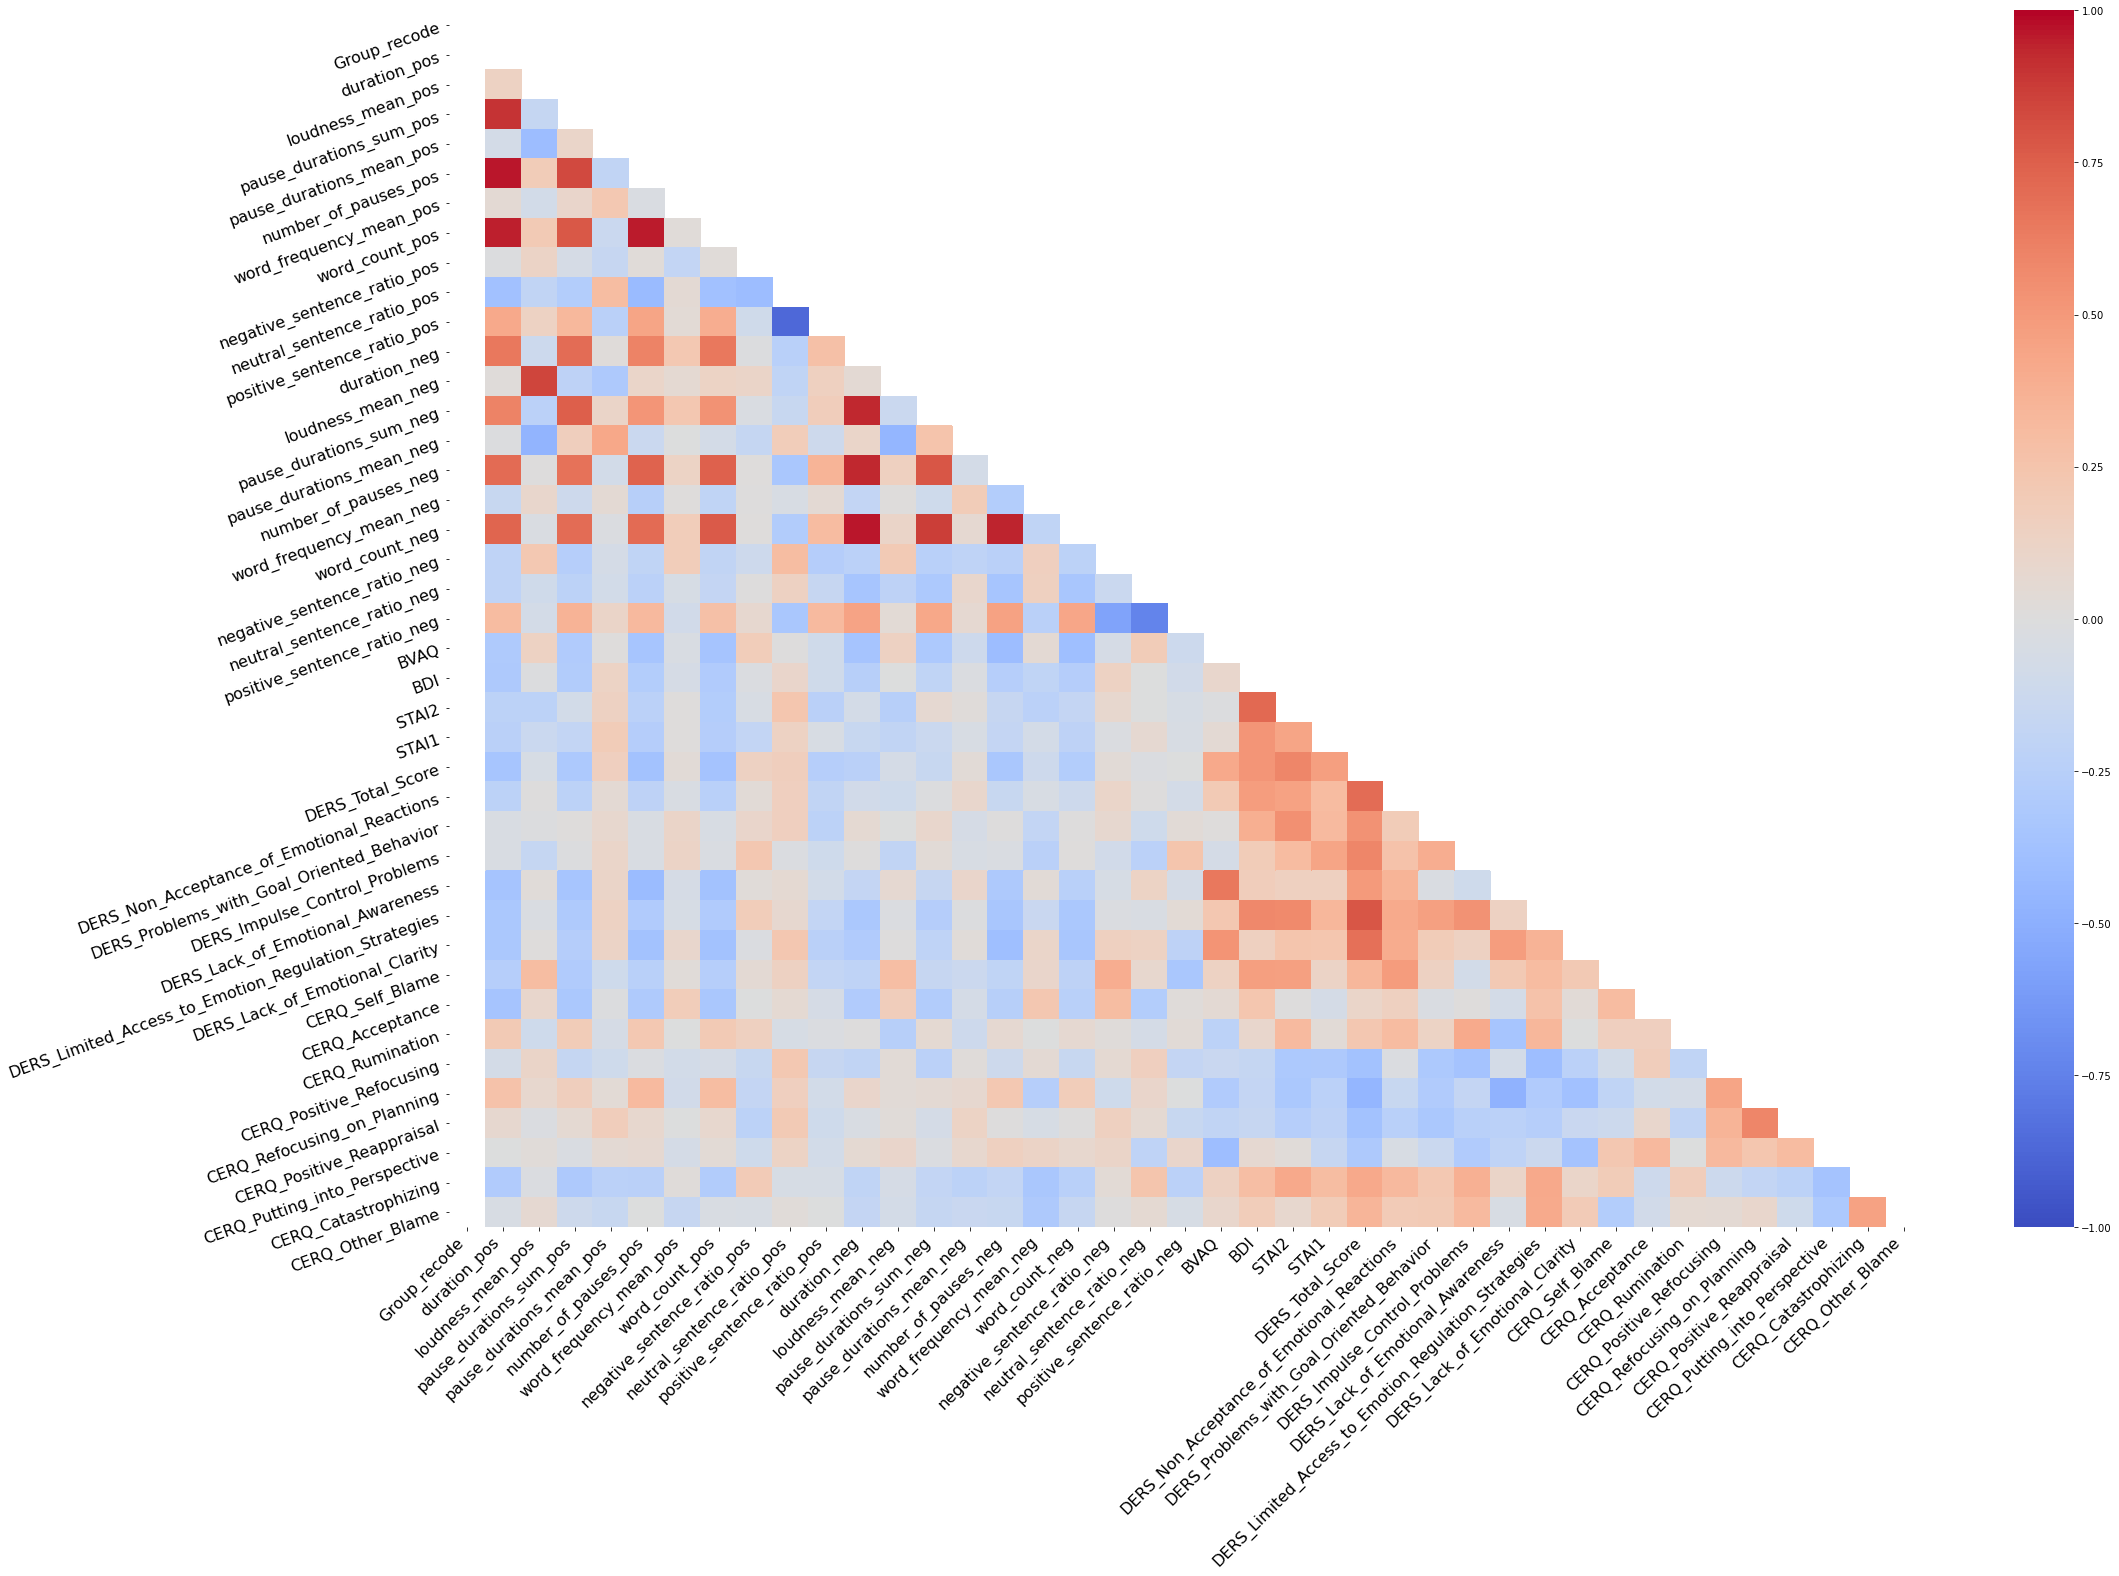

c:\Users\juhoffmann\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Correlation Matrix Summary:
Number of comparisons corrected for Bonferroni: 1681
Bonferroni correction threshold: 2.9744199881023203e-05
P-Value Matrix Summary:
       Group_recode  duration_pos  loudness_mean_pos  pause_durations_sum_pos  \
count           1.0     40.000000          40.000000                40.000000   
mean            0.0      0.266509           0.484459                 0.221613   
std             NaN      0.346872           0.324319                 0.281271   
min             0.0      0.000000           0.000000                 0.000000   
25%             0.0      0.011294           0.195895                 0.019735   
50%             0.0      0.070028           0.465657                 0.069069   
75%             0.0      0.616645           0.836726                 0.304734   
max             0.0      0.980707           0.975269                 0.933911   

       pause_durations_mean_pos  number_of_pauses_pos  \
count                 40.000000             40.00000

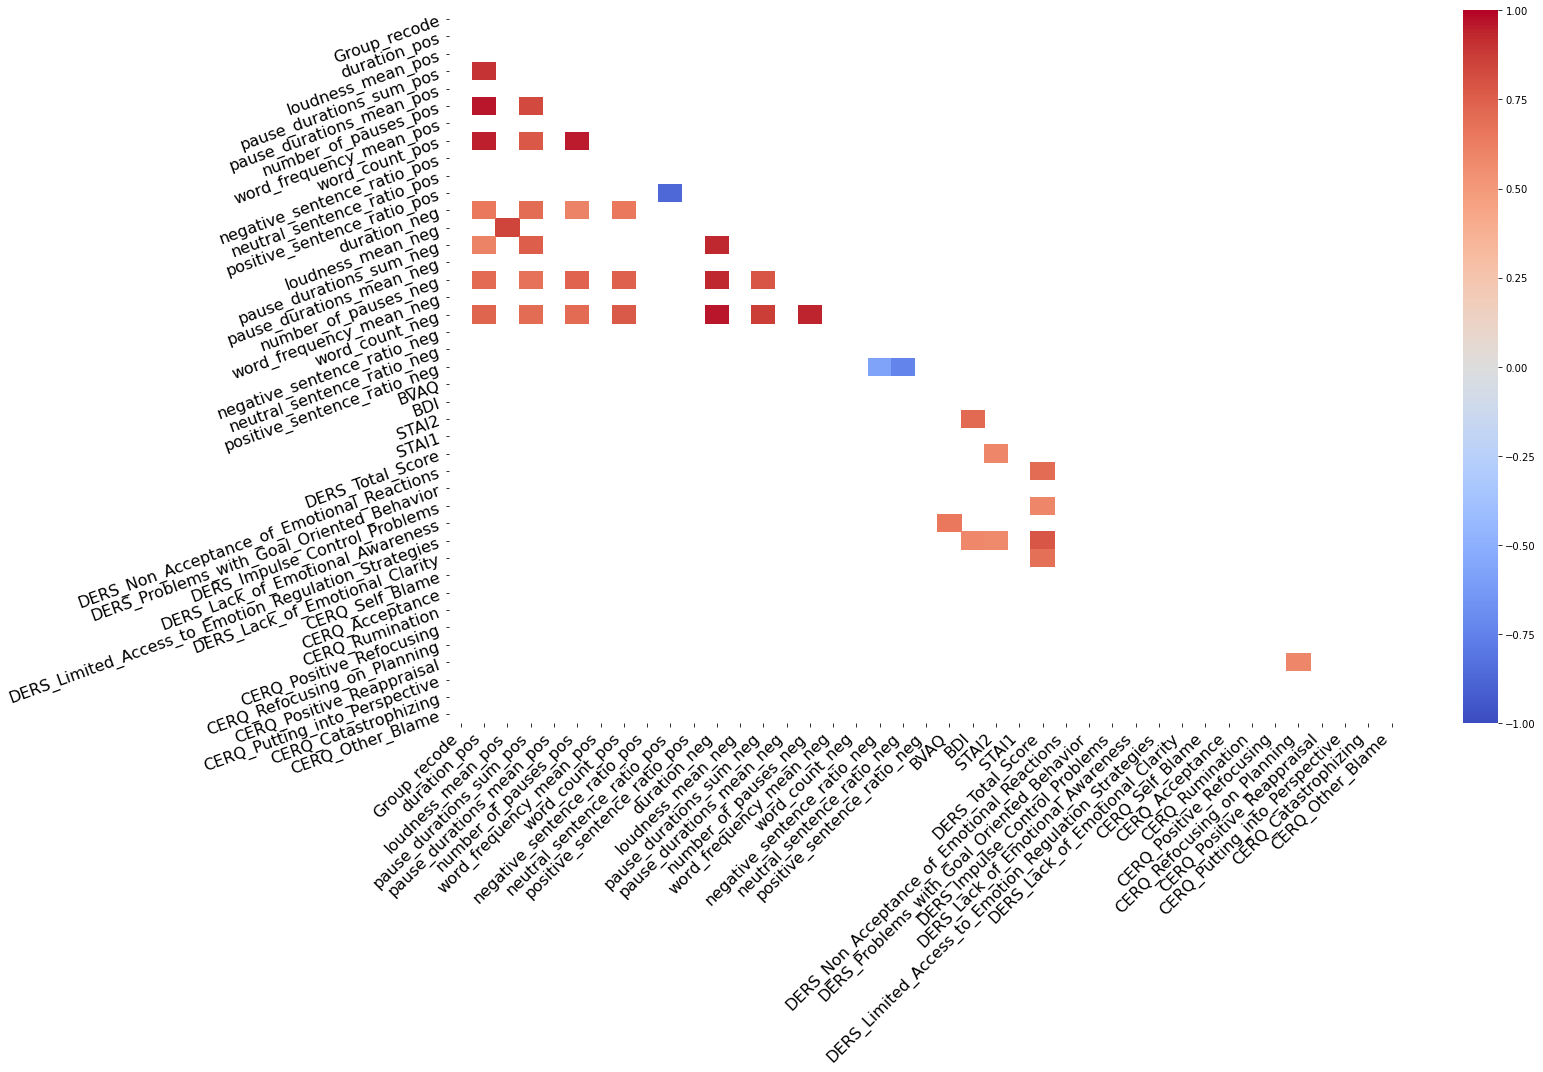

Significant Correlations Summary:
       Group_recode  duration_pos  loudness_mean_pos  pause_durations_sum_pos  \
count           0.0      8.000000           2.000000                 8.000000   
mean            NaN      0.813881           0.923798                 0.792673   
std             NaN      0.157134           0.107766                 0.112846   
min             NaN      0.608233           0.847596                 0.674465   
25%             NaN      0.692015           0.885697                 0.701308   
50%             NaN      0.814796           0.923798                 0.765406   
75%             NaN      0.955654           0.961899                 0.850833   
max             NaN      1.000000           1.000000                 1.000000   

       pause_durations_mean_pos  number_of_pauses_pos  \
count                       1.0              7.000000   
mean                        1.0              0.829323   
std                         NaN              0.150738   
min     

In [30]:
# Calculate the correlation matrix and the corresponding p-values matrix
groups = [0, 1]

def calculate_correlations(df):
    correlations = df.corr()
    p_values = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*correlations.shape)
    return correlations, p_values


# Loop through each group
for group in groups:
    print(f"Analyzing Group {group}...")
    
    # Filter the data for the current group
    analysis_df_group = df[df['Group_recode'] == group]

    # Compute the correlation matrix
    correlation_matrix = analysis_df_group.corr()

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

        # Plot the correlation matrix using a heatmap
    plt.figure(figsize=(32, 22))
    sns.heatmap(correlation_matrix, mask=mask, annot=False, fmt=".2f", cmap="coolwarm", cbar=True,vmin=-1, vmax=1) # Adjust vmin and vmax to -1 and 1 to cover the full range of correlations
    #plt.title(f'Correlation Matrix between Speech Features and Questionnaire Results for Group {group}')
    plt.xticks(rotation=45, ha='right', fontsize=16)
    plt.yticks(rotation=20, fontsize=16)
    plt.tight_layout()
    plt.savefig(f'C:/Users/juhoffmann/OneDrive - Uniklinik RWTH Aachen/Paper/2024_VideoMask/significant_correlation_matrix_group_all{group}.jpg')
    plt.show()

    # Calculate the correlation matrix and the corresponding p-values matrix for the current group
    correlation_matrix, p_values = calculate_correlations(analysis_df_group)

    # Debugging: Print a summary of the correlation matrix
    print("Correlation Matrix Summary:")
    correlation_matrix.describe()  # Check for the presence of both positive and negative correlations

    # Apply Bonferroni correction
    alpha = 0.05
    num_tests = p_values.size
    bonferroni_threshold = alpha / num_tests

    # Print the information for Bonferroni correction
    print(f"Number of comparisons corrected for Bonferroni: {num_tests}")
    print(f"Bonferroni correction threshold: {bonferroni_threshold}")

    # Create a mask for significant correlations
    significant_mask = (p_values < bonferroni_threshold)

    # Debugging: Check the range of p-values
    print("P-Value Matrix Summary:")
    print(p_values.describe())  # Ensure p-values cover the expected range

    # Mask insignificant correlations in the correlation matrix
    significant_correlations = correlation_matrix.where(significant_mask)

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(significant_correlations, dtype=bool))

    # Plot the significant correlations using a heatmap
    plt.figure(figsize=(23, 15))
    sns.heatmap(significant_correlations, mask=mask, annot=False, fmt=".2f", cmap="coolwarm", cbar=True,vmin=-1, vmax=1)
    #plt.title(f'Significant Correlations (Bonferroni-corrected) between Speech Features and Questionnaire Results for Group {group}', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=16)
    plt.yticks(rotation=20, fontsize=16)
    plt.tight_layout()
    plt.savefig(f'C:/Users/juhoffmann/OneDrive - Uniklinik RWTH Aachen/Paper/2024_VideoMask/significant_correlation_matrix_group_{group}.jpg')
    plt.show()
    
    # Debugging: Print significant correlations before storing them
    print("Significant Correlations Summary:")
    print(significant_correlations.describe())  # Check if negative correlations are being filtered out
    
    # Extract significant correlations
    significant_pairs = []

    for row in range(correlation_matrix.shape[0]):
        for col in range(row+1, correlation_matrix.shape[1]):
            var1 = correlation_matrix.index[row]
            var2 = correlation_matrix.columns[col]
            if p_values.iloc[row, col] < bonferroni_threshold:
                significant_pairs.append({
                    'Variable1': var1,
                    'Variable2': var2,
                    'Correlation': correlation_matrix.iloc[row, col],
                    'P-Value': p_values.iloc[row, col]
                })

    # Convert the list of significant pairs to a DataFrame
    significant_pairs_df = pd.DataFrame(significant_pairs).drop_duplicates(subset=['Variable1', 'Variable2'])

    # Save the significant correlations to a CSV file
    significant_pairs_df.to_csv(f'C:/Users/juhoffmann/OneDrive - Uniklinik RWTH Aachen/Paper/2024_VideoMask/speech_questionnaire_correlation_corrected_group_{group}.csv', index=False)

    print(f"Analysis for Group {group} completed.\n")

In [31]:
significant_correlations

,Group_recode,duration_pos,loudness_mean_pos,pause_durations_sum_pos,pause_durations_mean_pos,number_of_pauses_pos,word_frequency_mean_pos,word_count_pos,negative_sentence_ratio_pos,neutral_sentence_ratio_pos,...,DERS_Lack_of_Emotional_Clarity,CERQ_Self_Blame,CERQ_Acceptance,CERQ_Rumination,CERQ_Positive_Refocusing,CERQ_Refocusing_on_Planning,CERQ_Positive_Reappraisal,CERQ_Putting_into_Perspective,CERQ_Catastrophizing,CERQ_Other_Blame
Group_recode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration_pos,NaN,1.000000,NaN,0.901287,NaN,0.965558,NaN,0.952353,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loudness_mean_pos,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pause_durations_sum_pos,NaN,0.901287,NaN,1.000000,NaN,0.834016,NaN,0.774232,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pause_durations_mean_pos,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number_of_pauses_pos,NaN,0.965558,NaN,0.834016,NaN,1.000000,NaN,0.954556,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
word_frequency_mean_pos,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
word_count_pos,NaN,0.952353,NaN,0.774232,NaN,0.954556,NaN,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negative_sentence_ratio_pos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neutral_sentence_ratio_pos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Moderation Analysis

In [ ]:
# Initialize lists to store results
results = []

# Loop through each speech feature (dependent variable)
for speech_feature in speech_col:
    # Loop through each questionnaire feature (independent variable)
    for questionnaire_feature in questionnaire_col:
        # Standardize the variables
        df[speech_feature + '_z'] = (df[speech_feature] - df[speech_feature].mean()) / df[speech_feature].std()
        df[questionnaire_feature + '_z'] = (df[questionnaire_feature] - df[questionnaire_feature].mean()) / df[questionnaire_feature].std()
        df['Group_recode_z'] = (df['Group_recode'] - df['Group_recode'].mean()) / df['Group_recode'].std()

        # Create interaction term
        df['interaction'] = df[questionnaire_feature + '_z'] * df['Group_recode_z']

        # Define the formula for moderation
        formula = f'{speech_feature}_z ~ {questionnaire_feature}_z + Group_recode_z + interaction'

        # Fit the model
        model = smf.ols(formula=formula, data=df).fit()

        # Collect results
        results.append({
            'speech_feature': speech_feature,
            'questionnaire_feature': questionnaire_feature,
            'interaction_coefficient': model.params['interaction'],
            'interaction_pvalue': model.pvalues['interaction']
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Correct for multiple comparisons (FDR correction)
results_df['adjusted_pvalue'] = multipletests(results_df['interaction_pvalue'], method='fdr_bh')[1]

# Filter significant results (if desired)
significant_results = results_df[results_df['adjusted_pvalue'] < 0.05]

# Display results
print(significant_results)

# Optionally, save to a CSV for further review
#significant_results.to_csv("W:/Fmri_Forschung/Allerlei/JuliaS/GitHub/SubliminalVideoPriming/data\/speech/Moderation_Analysis_Results.csv", index=False)
results_df.to_csv("W:/Fmri_Forschung/Allerlei/JuliaS/GitHub/SubliminalVideoPriming/data\/speech/Moderation_Analysis_Results.csv", index=False)


Empty DataFrame
Columns: [speech_feature, questionnaire_feature, interaction_coefficient, interaction_pvalue, adjusted_pvalue]
Index: []


In [37]:
significant_results = results_df[results_df['interaction_pvalue'] < 0.05]
significant_results.to_csv("W:/Fmri_Forschung/Allerlei/JuliaS/GitHub/SubliminalVideoPriming/data\/speech/Moderation_Analysis_Results.csv", index=False)